# Steam Games Recommendation System Using K-means Clustering
## Understanding How It Works

This notebook demonstrates a hybrid recommendation system that combines collaborative filtering with content-based approaches using K-means clustering. We'll walk through each step of the process, from data loading to generating recommendations.

### 1. Initial Setup and Imports

Let's start by importing our custom recommender and setting the data source:

In [1]:
from scripts.kmeans_recommender import HybridClusterRecommender

data_dir = "processed_data"

### 2. Understanding the Components

Our recommender system combines several key components:

1. **Content-based features**: Uses game tags to understand game characteristics
2. **Collaborative filtering**: Leverages user behavior patterns through clustering
3. **Hybrid scoring**: Combines tag similarity with cluster-based recommendations

The system works in several stages:

#### 2.1 Data Loading and Processing
Let's initialize our recommender system and start exploring how it processes data and trains the model:


In [2]:
recommender = HybridClusterRecommender(data_dir=data_dir)

# Load the model or train if it does not exist
if not recommender.model_persistence.load_model(recommender):
    print("Training new model...")
    recommender.train(auto_k=True, save_model=True)

Loading model components...


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



Model loaded successfully!
Number of clusters: 16
Number of users: 831574
Number of games: 39545
Number of unique tags: 441


The training process involves several sophisticated steps that transform raw gaming data into meaningful user representations. Let's examine each phase in detail:

### Data Loading Phase

The system begins by loading three essential data sources:
```python
self.games_df = self.data_loader.load_games_data()                # Game information
metadata_list = self.data_loader.load_metadata()                  # Game metadata
recommendations_chunks = self.data_loader.load_recommendations()  # User interactions
```

The metadata is transformed into a more efficient dictionary structure where each game's tags are stored as a set for quick lookup operations:
```python
self.game_tags = {
    str(game['app_id']): set(game['tags'])
    for game in metadata_list
}
```

### Feature Extraction Phase

The system then processes user interactions to build comprehensive user profiles. For each user, it captures:

```python
user_features = {
    'games': defaultdict(float),        # Maps game_id to rating
    'total_hours': 0,                   # Total gameplay hours
    'preferred_tags': defaultdict(int), # Tag preference scores
    'positive_ratio': 0,                # Ratio of positive recommendations
    'n_games': 0                        # Number of games played
}
```

When processing each user interaction, the system updates these features intelligently. For instance, when a user recommends a game positively, all tags associated with that game receive a +1 boost in the user's preferred_tags, while negative recommendations result in a -0.5 penalty. This weighted approach helps build a nuanced understanding of user preferences.

### Feature Matrix Creation

The system then constructs a feature matrix for clustering:
```python
n_features = len(self.tags_list) + 2  # tags + hours + positive ratio
feature_matrix = np.zeros((len(self.users), n_features))

# Normalize features for each user
for user_idx, user_id in enumerate(self.users):
    user = self.user_features[user_id]

    # Add normalized tag preferences
    for tag, count in user['preferred_tags'].items():
        if tag in tag_to_idx:
            feature_matrix[user_idx, tag_to_idx[tag]] = count / user['n_games']

    # Add behavioral features
    feature_matrix[user_idx, -2] = user['total_hours'] / user['n_games']
    feature_matrix[user_idx, -1] = user['positive_ratio']
```

### Optimal Cluster Selection

When auto_k is enabled, the system employs the elbow method to determine the optimal number of clusters. This process works by:

1. Testing a range of cluster numbers (typically 5-30)
2. Computing the distortion (within-cluster sum of squares) for each value
3. Finding the "elbow point" where adding more clusters yields diminishing returns

```python
distortions = []
k_values = range(k_range[0], k_range[1] + 1)

# Calculate distortion for different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(self.feature_matrix)
    distortions.append(kmeans.inertia_)

# Find elbow point using KneeLocator
elbow_locator = KneeLocator(
    list(k_values),
    distortions,
    curve='convex',
    direction='decreasing'
)
optimal_k = elbow_locator.elbow
```

This approach ensures we choose a number of clusters that balances model complexity with clustering quality. The elbow point represents where additional clusters start providing less value, helping us avoid both underfitting and overfitting.

### Final Model Training

Once the optimal k is determined, the system trains the final model:
```python
self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
self.user_clusters = self.kmeans.fit_predict(self.feature_matrix)
```

Each cluster's profile is then computed, including:
- Most common tags
- Average playing time
- Typical rating patterns
- Popular games within the cluster

This rich cluster profiling enables the system to make informed recommendations based on both individual user preferences and the collective wisdom of similar users within the same cluster.



#### 2.2 Feature Engineering
Let's examine how user features are constructed.

The feature matrix combines:
- Tag preference vectors
- Gameplay statistics (hours played)
- Rating behavior (positive ratio)

In [3]:
recommender.load_feature_matrix()
print(f"Feature matrix shape: {recommender.feature_matrix.shape}")

sample_user = list(recommender.user_features.keys())[0]
print("\nExample user features:")
for key, value in recommender.user_features[sample_user].items():
    if isinstance(value, dict):
        print(f"{key}: {len(value)} items")
    else:
        print(f"{key}: {value}")

Creating feature matrix for clustering...
Feature matrix shape: (831574, 443)

Example user features:
games: 16 items
total_hours: 232.0
preferred_tags: 133 items
positive_ratio: 0.5625
n_games: 16


#### 2.3 Clustering Analysis

The system uses K-means clustering to group similar users. Let's visualize the clusters:


Generating visualization analysis...


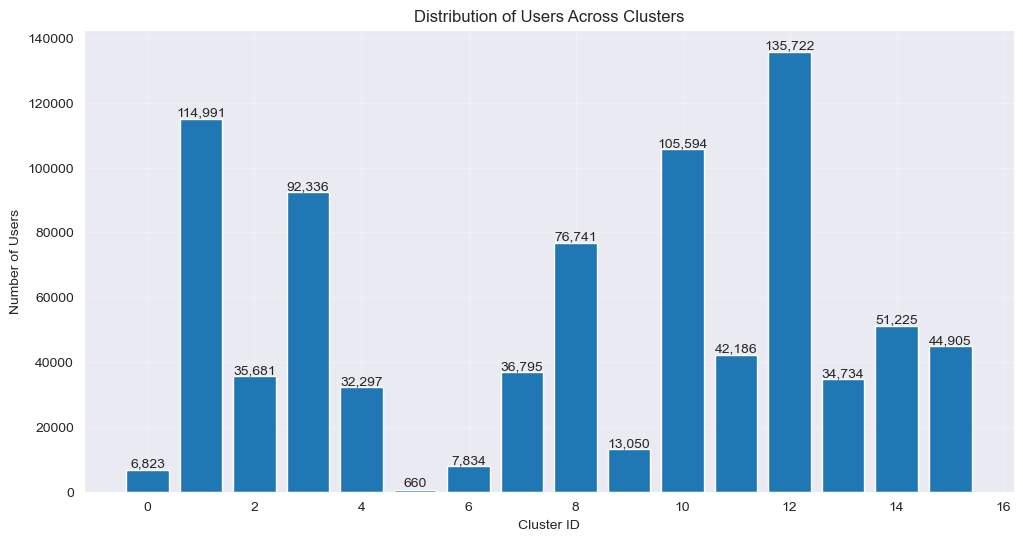

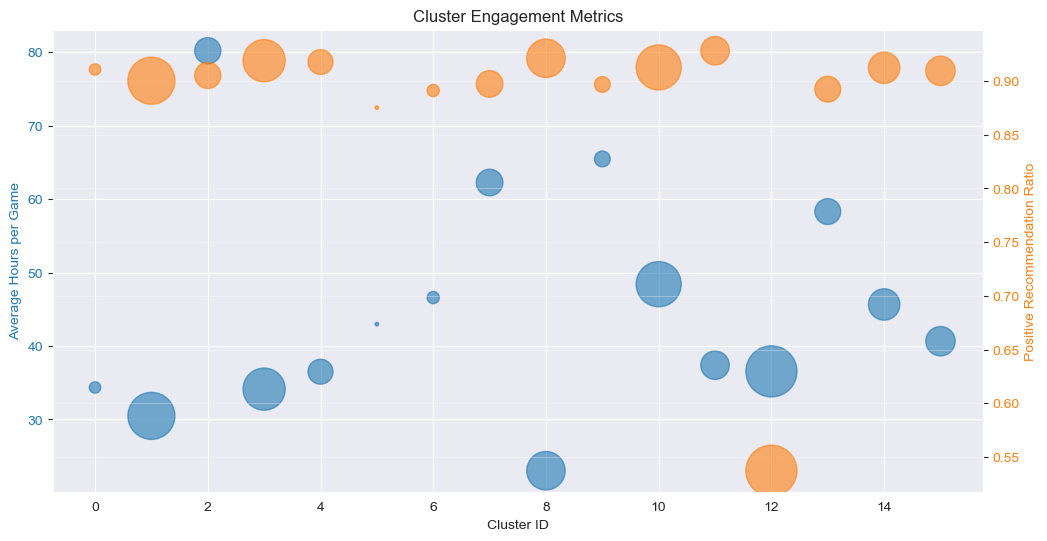

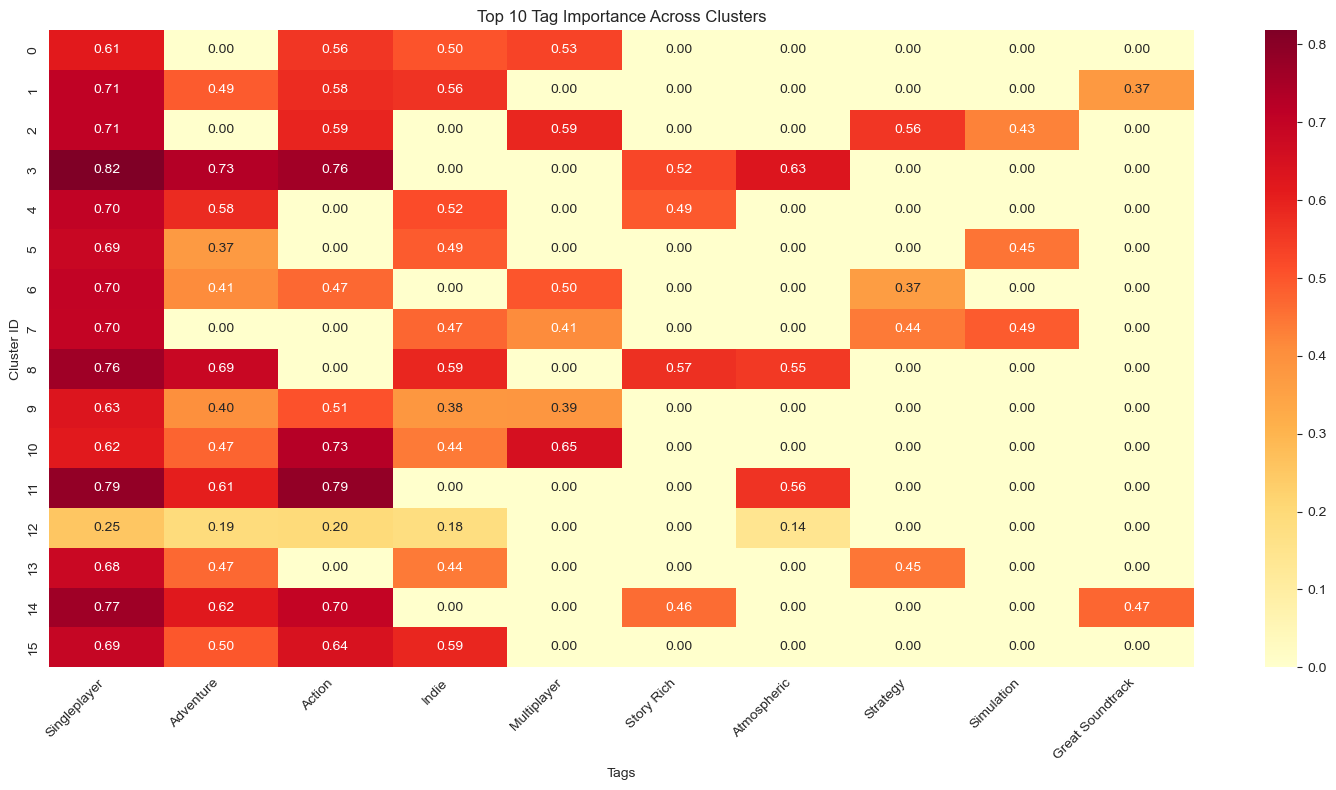

In [4]:
recommender.visualizer.plot_all_analyses()

These visualizations help us understand:
- How users are distributed across clusters
- The characteristics of each cluster
- Which tags are most important for different user groups

#### 2.4 Generating Recommendations

Let's see how recommendations are generated for a sample user:

In [5]:
import random

sample_user = random.choice(recommender.users)
recommender.display_user_analysis(sample_user)

Loading games data...

=== Random User Analysis (ID: 4106457) ===
Cluster: 1

User Statistics:
Total games played: 5
Average hours per game: 46.6
Positive recommendation ratio: 100.0%

User's Top Tags:
- Adventure: 4.0
- Action: 4.0
- Singleplayer: 4.0
- Story Rich: 3.0
- Indie: 3.0

Top 10 Recommended Games:
Game Title                                         Score      Top Tags
------------------------------------------------------------------------------------------
LIMBO                                              0.512      Puzzle Platformer, Minimalist, Singleplayer
Hotline Miami                                      0.488      Singleplayer, Atmospheric, Psychedelic
Hotline Miami 2: Wrong Number                      0.482      Singleplayer, Atmospheric, Top-Down Shooter
Half-Life 2                                        0.479      Singleplayer, Atmospheric, First-Person
Super Meat Boy                                     0.474      Time Attack, 2D Platformer, Singleplayer
Katana ZE

The recommendation process involves:
1. Identifying the user's cluster
2. Finding popular games within that cluster
3. Adjusting recommendations based on:
   - Tag similarity
   - Play time patterns
   - Rating behavior

### 3. Understanding the Scoring System

The final recommendation score combines multiple factors:

In [6]:
def explain_scoring(recommender, user_id, game_id):
    """Explain how a game's recommendation score is calculated"""
    if game_id not in recommender.game_tags:
        return "Game not found in database"

    user_data = recommender.user_features[user_id]
    user_cluster = recommender.user_clusters[recommender.user_to_idx[user_id]]

    # Get cluster score
    cluster_scores = dict(recommender.cluster_recommendations[user_cluster])
    cluster_score = cluster_scores.get(game_id, 0)

    # Calculate tag similarity
    user_tags = set(tag for tag, score in user_data['preferred_tags'].items() if score > 0)
    game_tags = recommender.game_tags[game_id]
    tag_similarity = len(user_tags & game_tags) / len(user_tags | game_tags) if game_tags else 0

    final_score = 0.5 * cluster_score + 0.5 * tag_similarity

    return {
        'cluster_score': cluster_score,
        'tag_similarity': tag_similarity,
        'final_score': final_score
    }

recommendations = recommender.get_recommendations(sample_user, n_recommendations=1)
if recommendations:
    game_id, game_info = recommendations[0]
    scores = explain_scoring(recommender, sample_user, game_id)
    print(f"\nScoring breakdown for game {game_info['title']}:")
    for component, score in scores.items():
        print(f"{component}: {score:.3f}")


Scoring breakdown for game Hotline Miami:
cluster_score: 0.801
tag_similarity: 0.175
final_score: 0.488


### 4. Evaluating Performance

We can analyze the quality of recommendations by looking at:
1. Cluster cohesion
2. Tag relevance
3. User engagement patterns

In [7]:
cluster_stats = recommender.analyze_clusters()

print("\nCluster Statistics:")
for cluster, stats in cluster_stats.items():
    print(f"\nCluster {cluster}:")
    print(f"Size: {stats['size']} users")
    print(f"Average hours per game: {stats['avg_hours']:.1f}")
    print(f"Positive ratio: {stats['avg_positive_ratio']:.2f}")
    print("Top tags:", ', '.join(tag for tag, _ in stats['top_tags'][:3]))


Cluster Statistics:

Cluster 0:
Size: 6823 users
Average hours per game: 34.4
Positive ratio: 0.91
Top tags: Singleplayer, Action, Multiplayer

Cluster 1:
Size: 114991 users
Average hours per game: 30.5
Positive ratio: 0.90
Top tags: Singleplayer, Action, Indie

Cluster 2:
Size: 35681 users
Average hours per game: 80.2
Positive ratio: 0.91
Top tags: Singleplayer, Action, Multiplayer

Cluster 3:
Size: 92336 users
Average hours per game: 34.1
Positive ratio: 0.92
Top tags: Singleplayer, Action, Adventure

Cluster 4:
Size: 32297 users
Average hours per game: 36.5
Positive ratio: 0.92
Top tags: Singleplayer, Anime, Adventure

Cluster 5:
Size: 660 users
Average hours per game: 43.0
Positive ratio: 0.88
Top tags: Singleplayer, Indie, Simulation

Cluster 6:
Size: 7834 users
Average hours per game: 46.6
Positive ratio: 0.89
Top tags: Singleplayer, Multiplayer, Action

Cluster 7:
Size: 36795 users
Average hours per game: 62.3
Positive ratio: 0.90
Top tags: Singleplayer, Simulation, Indie

Clus

## Analysis of the K-means Based Steam Game Recommender System

### Strengths

The system's primary strength lies in its scalability through clustering, which effectively handles the computational challenges typically associated with large-scale recommendation systems. By grouping users into clusters, it dramatically reduces the computational overhead compared to traditional collaborative filtering approaches that require calculating similarities between all users or items.

The hybrid architecture represents another significant advantage, combining content-based filtering through game tags with collaborative filtering through user clustering. This dual approach creates a more robust system that can capture both explicit content preferences and implicit user behavior patterns. This system strength, is in its feature engineering, where it normalizes tag preferences by play time and incorporates behavioral patterns through hours played and rating ratios.

Cold start handling, a common challenge in recommendation systems, is managed effectively through cluster-based defaults and tag similarity matching. New users can quickly receive relevant recommendations based on their initial interactions, while the system continues to refine these suggestions as more data becomes available.

### Weaknesses

The static nature of the model represents its most significant limitation. The system requires complete retraining to incorporate new data, and it cannot adapt dynamically to evolving user preferences or gaming trends. This rigidity could lead to increasingly outdated recommendations if not regularly retrained.

Contextual awareness presents another area of concern. The system operates without consideration for important temporal factors such as game release dates or gaming sessions. It also lacks awareness of crucial contextual elements like:
- Seasonal gaming trends
- Price sensitivity patterns
- Social gaming relationships
- Playing time patterns

The choice of K-means clustering, while computationally efficient, introduces inherent limitations. The algorithm assumes spherical clusters of similar sizes and requires predetermining the number of clusters. These assumptions may not align well with the natural grouping of user preferences in the gaming domain.

Memory requirements pose a practical challenge, particularly at scale. The system needs to maintain several large data structures in memory:
- Complete feature matrices
- Cluster profiles
- User-cluster mappings
- Tag dictionaries

### Potential Improvements

The system could be significantly enhanced by implementing dynamic updates that allow for continuous model adaptation without full retraining. This could include incremental learning capabilities and time-weighted preference scoring to capture evolving gaming trends. Contextual enrichment would add another dimension of sophistication. By incorporating temporal gaming patterns and social network information, the system could provide more nuanced and timely recommendations. The addition of session-based analysis would help capture short-term interest fluctuations alongside long-term preferences. The recommendation diversity issue could be addressed through a more sophisticated scoring system that balances similarity with novelty. This would help prevent echo chambers while maintaining recommendation relevance.

### Conclusion

The current implementation provides a solid foundation for a scalable game recommendation system. Its hybrid approach and sophisticated feature engineering demonstrate a good balance between theoretical soundness and practical applicability. While the static nature and limited contextual awareness present clear limitations, these could be addressed through targeted enhancements to the existing architecture.